# <div style="color:rgb(200,180,180);font-size:42px;"><u>***UCI Breast Cancer Pipeline Project***</u></div>
### **Some noteworthy information from UCI:**
1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

### **Ten real-valued features are computed for each cell nucleus:**

1) radius (mean of distances from center to points on the perimeter)
2) texture (standard deviation of gray-scale values)
3) perimeter
4) area
5) smoothness (local variation in radius lengths)
6) compactness (perimeter^2 / area - 1.0)
7) concavity (severity of concave portions on the contour)
8) concave points (number of concave portions of the contour)
9) symmetry
10) fractal dimension ("coastline approximation" - 1)
###


## 0. Import Modules:

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes as ax

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

## 1. Import UCI Dataset &#8594; Write Dataset to Local CSV

In [68]:
## Import UCI Dataset and write to local csv
## NOTE: Commented out code for the sake of minimizing runtime, it is functional/reusable.
# from ucimlrepo import fetch_ucirepo
# breast_ca = fetch_ucirepo(id=17)

# breast_ca_df = breast_ca.data.original
# breast_ca_df.to_csv('UCI_BreastCancer.csv', index=False)
# print('Successfully wrote dataset to csv file!')

# Read csv and store as df
df = pd.read_csv('UCI_BreastCancer.csv')

## 2. Search for missing values and verify shape &#8594; Identify Feature Types

In [69]:
# Search Dataset for missing / null values:
try:
    if df.isnull().sum().any()>0:
        print('NaN values found: ', df.isnull().sum())
    else:
        print('No NaN or null values found')
except Exception as e:
    print(e)

# Consider the number of unique values for each feature:
# All features are numeric.
# print(df.nunique())

# Verify features and shape:
print(df.columns)
print(df.shape)

No NaN or null values found
Index(['ID', 'radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
       'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
       'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
       'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
       'symmetry3', 'fractal_dimension3', 'Diagnosis'],
      dtype='object')
(569, 32)


## 3. Define Target (y) and Features (X) &#8594; Convert Target to Binary &#8594; Train_Test_Split()

In [70]:
# Define features and target
y = df.Diagnosis
X = df.drop(columns=['Diagnosis','ID'])
print(X.shape)
print(y.shape)

# Convert target data to binary and verify value_counts.
print('\nPrior to binary conversion: \n',y.value_counts())
try:
    y = pd.DataFrame(np.where(y == 'M',1,0), columns=['Diagnosis'])
    y = y.Diagnosis
    print('\nPost binary conversion: \n',y.value_counts(),'\n')

except Exception as e:
    print(e)

print(X.shape)
print(y.shape)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

(569, 30)
(569,)

Prior to binary conversion: 
 Diagnosis
B    357
M    212
Name: count, dtype: int64

Post binary conversion: 
 Diagnosis
0    357
1    212
Name: count, dtype: int64 

(569, 30)
(569,)


## 4. PCA, Lasso L1 Regularization, and Exploratory Data Analysis:

In [71]:
# BLOCK 4 In progress ...

## 4.1. Lasso L1 Regularization

Lasso(alpha=0.0005) score:	 0.725 		Number of features with a non-zero coef:  26
Lasso(alpha=0.002) score:	 0.730 		Number of features with a non-zero coef:  24
Lasso(alpha=0.005) score:	 0.718 		Number of features with a non-zero coef:  19
Lasso(alpha=0.05) score:	 0.666 		Number of features with a non-zero coef:  5

Best score: 
0.730


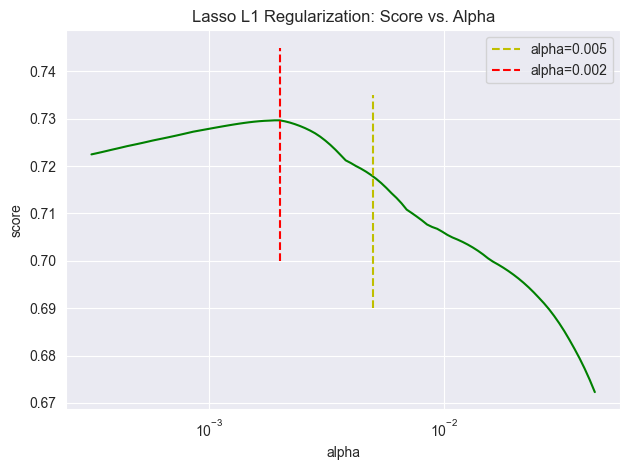

<Figure size 640x480 with 0 Axes>

In [72]:
# Initialize scaler and fit_transform:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to show scores and number of features with non-zero coefficients:
show_list = [0.0005,0.002,0.005,0.05]
for i in show_list:
    reg = Lasso(alpha=i)
    reg.fit(X_train_scale,y_train)
    coefs = pd.Series(reg.coef_,X.columns)
    print(f'Lasso(alpha={i}) score:\t',f'{reg.score(X_test_scale, y_test):.3f}',
          '\t\tNumber of features with a non-zero coef: ', coefs[reg.coef_ != 0].shape[0])

# Loop to analyze for any meaningful impact of alpha on the score:
score_list = list()
try:
    for i in np.logspace(-3.5,-1.36,100):
        reg = Lasso(alpha=i)
        reg.fit(X_train_scale,y_train)
        coefs = pd.Series(reg.coef_,X.columns)
        score_list.append([i,reg.score(X_test_scale, y_test)])
except Exception as e:
    print(e)

c_names = ['alpha:','score:']
score_df = pd.DataFrame(score_list,columns=c_names)
max_score = score_df['score:'].max()
print(f'\nBest score: \n{max_score:.3f}')

plt.plot(score_df['alpha:'],score_df['score:'],color='green',scalex=True)
plt.plot([0.005,0.005],[0.69,0.735],color='y',linestyle='--',label='alpha=0.005')
plt.plot([0.002,0.002],[0.70,0.745],color='red',linestyle='--',label='alpha=0.002')
plt.legend()
plt.xlabel('alpha')
plt.xscale('log')
plt.ylabel('score')
plt.title('Lasso L1 Regularization: Score vs. Alpha')
plt.tight_layout()
plt.show()
plt.clf()

## 4.1.1. Lasso L1 Regularization - Coefficients

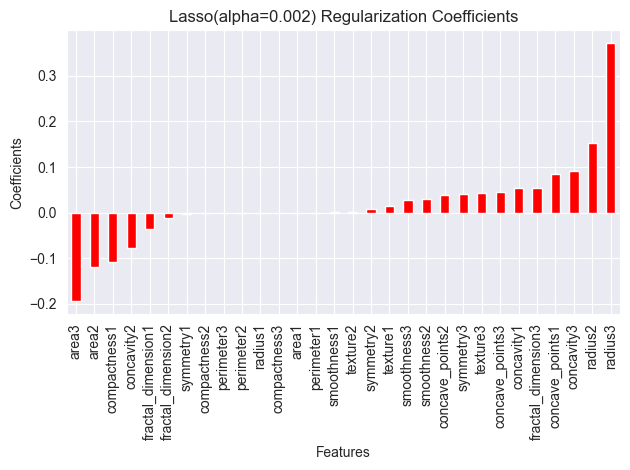

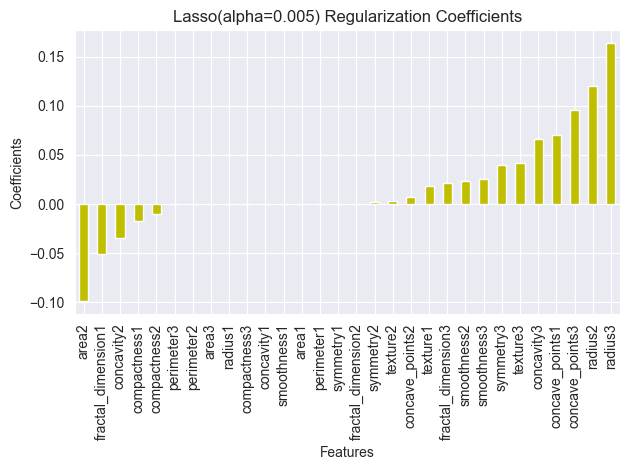

<Figure size 640x480 with 0 Axes>

In [73]:
# Supporting visuals for Lasso L1 Regularization tuning of alpha:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Plot of alpha=0.002 (RED)
reg = Lasso(alpha=0.002)
reg.fit(X_train_scale,y_train)
coefs = pd.Series(reg.coef_,X.columns).sort_values()
coefs.plot(kind='bar',color='red')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso(alpha=0.002) Regularization Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.clf()

# Plot of alpha=0.005 (YELLOW)
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)
coefs = pd.Series(reg.coef_,X.columns).sort_values()
coefs.plot(kind='bar',color='y')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso(alpha=0.005) Regularization Coefficients')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.clf()


## 4.1.2. Lasso L1 Regularization - Feature Selection
*<div style="font-size:16px;color:lightpink"> *Note: Defining new Lasso features training / testing sets as* **X_L_train** *and* **X_L_test** </div>*

In [74]:
# Using alpha=0.005 (19 features with non-zero coefficients)

# Ensure a known starting condition before fitting Lasso:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit Lasso with alpha=0.005:
reg = Lasso(alpha=0.005)
reg.fit(X_train_scale,y_train)

# Select features with coefficients > 0.001:
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_L_train = X_train_scale[X_train_scale.columns[np.abs(reg.coef_) > 0.001]]

X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_L_test = X_test_scale[X_test_scale.columns[np.abs(reg.coef_) > 0.001]]

## DON'T Fall for this trap!
# X_L_test = X_test_scale[X_test_scale.columns[coefs.abs() > 0.001]]
## Using coefs.abs() will produce incorrect features due to the sort_values() called on it.

# Verify expected shapes (19 features):
print(X_L_train.shape)
print(X_L_test.shape)

# Verify expected columns:
# print(X_L_train.columns)

(455, 19)
(114, 19)


## 4.1.3. Lasso L1 Regularization – Validating Feature Selection with RFC

In [75]:
# Compare the performance of RandomForestClassifier on X_L_train and X_L_test VS full feature set.

# Loop to fit RFC with Lasso features and the Full feature set, 50 times:
# About 15 sec runtime with 50 loop runs.
rfc_list = list()
for i in range(1,51):
    # LASSO FEATURE SET:
    clf_validate1 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    rfc_list.append([i+1,lasso_score,full_score])

c_names = ['random_state','lasso_score','full_score']
scores_df = pd.DataFrame(rfc_list,columns=c_names)
print('RFC Lasso Avg Score: \t\t:',scores_df['lasso_score'].mean())
print('RFC Full Avg Score: \t\t:',scores_df['full_score'].mean())
print('RFC Lasso Std Dev: \t\t\t:',scores_df['lasso_score'].std())
print('RFC Full Std Dev: \t\t\t:',scores_df['full_score'].std())

# LASSO feature set has a BIG improved average score and a lower std dev!
# While using only 19 of the 30 features!

RFC Lasso Avg Score: 		: 0.9698245614035088
RFC Full Avg Score: 		: 0.9224561403508771
RFC Lasso Std Dev: 			: 0.00871085072530464
RFC Full Std Dev: 			: 0.010538243629889059


## 4.1.4. Lasso L1 Regularization – Validating Feature Selection with SGDClassifier

In [76]:
# Compare the performance of SGDClassifier on X_L_train and X_L_test VS full feature set.
from sklearn.linear_model import SGDClassifier

# Loop to fit SGDClassifier with Lasso features and the Full feature set, 50 times:
# About 0.3 sec runtime with 50 loop runs.
sgd_list = list()
for i in range(1,51):
    # LASSO FEATURE SET:
    clf_validate1 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='hinge')
    clf_validate1.fit(X_L_train,y_train)
    lasso_score = clf_validate1.score(X_L_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = SGDClassifier(random_state=i+1,penalty='l2',alpha=0.01,loss='hinge')
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND RESULTS
    sgd_list.append([i+1,lasso_score,full_score])

c_names = ['random_state','lasso_score','full_score']
scores_df = pd.DataFrame(sgd_list,columns=c_names)
print('SGD Lasso Avg Score: \t\t:',scores_df['lasso_score'].mean())
print('SGD Full Avg Score: \t\t:',scores_df['full_score'].mean())
print('SGD Lasso Std Dev: \t\t\t:',scores_df['lasso_score'].std())
print('SGD Full Std Dev: \t\t\t:',scores_df['full_score'].std())

# LASSO feature set has a slightly improved average score and a similar std dev!
# While using only 19 of the 30 features!

SGD Lasso Avg Score: 		: 0.9845614035087717
SGD Full Avg Score: 		: 0.9814035087719298
SGD Lasso Std Dev: 			: 0.006525923090872937
SGD Full Std Dev: 			: 0.006046284752789365


## 4.2. Linear Discriminant Analysis (LDA)

In [77]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

# Initialize scaled training and testing data:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Initialize LDA and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)
print('LDA \'lsqr\' solver score: \t',clf.score(X_test_scale,y_test))

clf = LDA(solver='svd')
clf.fit(X_train_scale,y_train)
print('LDA \'svd\' solver score: \t',clf.score(X_test_scale,y_test))

clf = LDA(shrinkage=0.005,solver='eigen')
clf.fit(X_train_scale,y_train)
print('LDA \'eigen\' solver score: \t',clf.score(X_test_scale,y_test))

print('\nContinuing with \'lsqr\' solver to adjust shrinkage as desired.'
      '\nOnly \'lsqr\' and \'eigen\' are compatible with shrinkage.\n')

LDA 'lsqr' solver score: 	 0.9824561403508771
LDA 'svd' solver score: 	 0.9824561403508771
LDA 'eigen' solver score: 	 0.9824561403508771

Continuing with 'lsqr' solver to adjust shrinkage as desired.
Only 'lsqr' and 'eigen' are compatible with shrinkage.



## 4.2.1. Linear Discriminant Analysis – Coefficients


** NOTE: LDA does not drive coefficients to zero like Lasso (as seen above in block 4.1.1). **



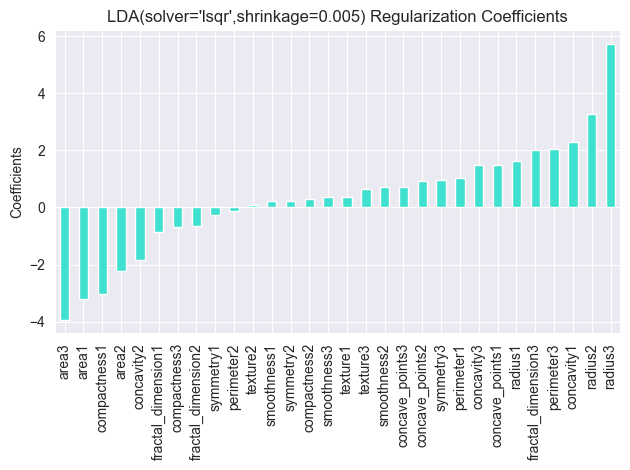


Accuracy score of LDA(solver="lsqr"): 	 0.9825
Number of features with coefs > 0.7: 	 19 



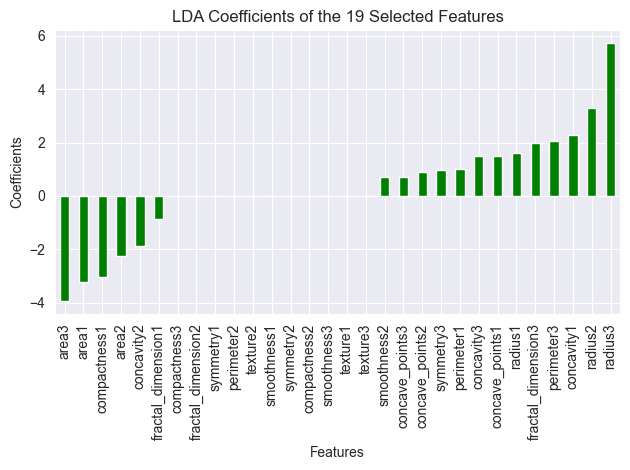

radius1 coef: 	 1.619
radius2 coef: 	 3.28
radius3 coef: 	 5.72




<Figure size 640x480 with 0 Axes>

In [78]:
# Initialize LDA using 'lsqr' and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)

print('\n** NOTE: LDA does not drive coefficients to zero like Lasso (as seen above in block 4.1.1). **\n')
# Bar Plot of resulting COEF_s:
coefs = pd.Series(clf.coef_[0],X.columns).sort_values()
coefs.plot(kind='bar',color='turquoise')
plt.xticks(rotation=90)
plt.ylabel('Coefficients')
plt.title('LDA(solver=\'lsqr\',shrinkage=0.005) Regularization Coefficients')
plt.tight_layout()
plt.show()
plt.clf()

# Selecting features based on the absolute value of the coef_ compared to a threshold:
feature_names = list()
feature_values = list()
features_lda = 0
threshold = 0.7
for i in range(0,len(coefs)):
    if np.abs(coefs.iloc[i]) > threshold:
        feature_names.append(coefs.index[i])
        feature_values.append(coefs.iloc[i])
        features_lda += 1
    else:
        feature_names.append(coefs.index[i])
        feature_values.append(0)

print(f'\nAccuracy score of LDA(solver="lsqr"): \t {clf.score(X_test_scale,y_test):.4f}')
print('Number of features with coefs > 0.7: \t', features_lda,'\n')


# Plot of the 19 Features Selected by LDA:
plot_lda = pd.Series(feature_values,index=feature_names)
plot_lda.plot(kind='bar',color='green')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('LDA Coefficients of the 19 Selected Features')
plt.tight_layout()
plt.show()
plt.clf()


print('radius1 coef: \t', coefs['radius1'].round(3))
print('radius2 coef: \t', coefs['radius2'].round(3))
print('radius3 coef: \t', coefs['radius3'].round(3))
print('\n')


## 4.2.2 Linear Discriminant Analysis – Feature Selection
*<div style="font-size:16px;color:lightpink"> *Note: Defining new LDA features training / testing sets as* **X_LDA_train** *and* **X_LDA_test** </div>*

In [79]:
# Initialize scaled training and testing data:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

# Initialize LDA and fit to training data:
clf = LDA(shrinkage=0.005,solver='lsqr')
clf.fit(X_train_scale,y_train)

# Define new training and testing sets as X_LDA_train, X_LDA_test
X_train_scale = pd.DataFrame(X_train_scale,columns=X.columns)
X_LDA_train = X_train_scale[X_train_scale.columns[np.abs(clf.coef_[0]) > 0.7]]
X_test_scale = pd.DataFrame(X_test_scale,columns=X.columns)
X_LDA_test = X_test_scale[X_test_scale.columns[np.abs(clf.coef_[0]) > 0.7]]

## DON'T fall for this trap!
# X_LDA_test = X_test_scale[X_test_scale.columns[coefs.abs() > 0.7]]
## Using coefs.abs() with load the incorrect features due to the sort_values() called on coefs.
## Instead reference the original clf.coef_ as it has maintained index order.

## Checking for expected features
# print(X_LDA_train.head())

print(X_LDA_train.shape)
print(X_LDA_test.shape)

(455, 19)
(114, 19)


## 4.2.3. Linear Discriminant Analysis – Validating Feature Selection with RFC

In [80]:
# Compare the performance of RandomForestClassifier on X_LDA_train and X_LDA_test VS full feature set.

# Loop to fit RFC with LDA features and the Full features set, 50 times:
# About 15 sec runtime with 50 loop runs.
rfc_list = list()
for i in range(1,51):
    # LDA FEATURE SET:
    clf_validate1 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate1.fit(X_LDA_train,y_train)
    LDA_score = clf_validate1.score(X_LDA_test,y_test)
    # FULL FEATURE SET:
    clf_validate2 = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    rfc_list.append([i+1,LDA_score,full_score])

c_names = ['random_state','LDA_score','full_score']
scores_df = pd.DataFrame(rfc_list,columns=c_names)
print('RFC LDA Avg Score: \t\t\t:',scores_df['LDA_score'].mean())
print('RFC Full Avg Score: \t\t:',scores_df['full_score'].mean())
print('RFC LDA Std Dev: \t\t\t:',scores_df['LDA_score'].std())
print('RFC Full Std Dev: \t\t\t:',scores_df['full_score'].std())

## The LDA feature set is underperforming compared to the Lasso Features


RFC LDA Avg Score: 			: 0.9050877192982455
RFC Full Avg Score: 		: 0.9224561403508771
RFC LDA Std Dev: 			: 0.003404280127119297
RFC Full Std Dev: 			: 0.010538243629889059


## 4.2.4. Linear Discriminant Analysis – Validating Feature Selection with SGDClassifier

In [81]:
# Compare the performance of SGDClassifier on X_LDA_train and X_LDA_test VS full feature set:

# Loop to fit SGDClassifier with LDA features and full features set, 50 times:
sgd_list = list()
for i in range(1,51):
    # Fit and score the LDA feature set:
    clf_validate1 = SGDClassifier(random_state=i+1,loss='hinge',penalty='l2',alpha=0.01)
    clf_validate1.fit(X_LDA_train,y_train)
    LDA_score = clf_validate1.score(X_LDA_test,y_test)
    # Fit and score the full feature set:
    clf_validate2 = SGDClassifier(random_state=i+1,loss='hinge',penalty='l2',alpha=0.01)
    clf_validate2.fit(X_train_scale,y_train)
    full_score = clf_validate2.score(X_test_scale,y_test)
    # APPEND
    sgd_list.append([i+1,LDA_score,full_score])


c_names = ['random_state','LDA_score','full_score']
scores_df = pd.DataFrame(sgd_list,columns=c_names)
print('SGD LDA Avg Score: \t\t\t:',scores_df['LDA_score'].mean())
print('SGD Full Avg Score: \t\t:',scores_df['full_score'].mean())
print('SGD LDA Std Dev: \t\t\t:',scores_df['LDA_score'].std())
print('SGD Full Std Dev: \t\t\t:',scores_df['full_score'].std())

# LDA feature set is underperforming compared to Lasso Features

SGD LDA Avg Score: 			: 0.965438596491228
SGD Full Avg Score: 		: 0.9814035087719298
SGD LDA Std Dev: 			: 0.009445995260673076
SGD Full Std Dev: 			: 0.006046284752789365


## 4.9. Prepare Classifier Switching Class:

In [82]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier

class ClfSwitch(BaseEstimator):
    def __init__(self, estimator=SGDClassifier()):
        self.estimator = estimator
    def fit(self,xx,yy=None,**kwargs):
        self.estimator.fit(xx,yy)
        return self
    def predict(self,xx,yy=None):
        return self.estimator.predict(xx)
    def predict_proba(self,xx,yy=None):
        return self.estimator.predict_proba(xx)
    def score(self,xx,yy):
        return self.estimator.score(xx,yy)

## 5. Define Pipeline / Preprocessing / Search_space

In [83]:
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, X_train.columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', ClfSwitch())
])

search_space = [
    {'clf__estimator': [RandomForestClassifier(random_state=13)],
     'clf__estimator__max_depth':[10,15,25],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [GradientBoostingClassifier(random_state=13)],
     'clf__estimator__learning_rate':[0.001,0.01,0.1],
     'clf__estimator__n_estimators':[150,200,250],
     },
    {'clf__estimator': [SGDClassifier(random_state=13)],
     'clf__estimator__loss': ['hinge','log_loss'],
     'clf__estimator__alpha': [0.001,0.005,0.01],
     'clf__estimator__penalty': ['l2']
     }
]

## 6. GridSearchCV Implementation &#8594; Analyze Results and Prepare to Tune Hyperparameters
*About 30 sec runtime with current search_space (9,9,6)*

In [84]:
# USE sklearn version 1.5.2 to suppress FutureWarning during fit:
gs = GridSearchCV(estimator=pipeline, param_grid=search_space, cv=5, error_score='raise')
gs.fit(X_train, y_train)

# Load the best estimator:
gs_best = gs.best_estimator_

# Load the best classifier:
gs_best_clf = gs_best.named_steps['clf']

# Print the best classifier's estimator:
print(gs_best_clf.get_params()['estimator'])

## Parameters can be accessed using:
#print(gs_best_clf.get_params()['estimator__max_depth'])
#print(gs_best_clf.get_params()['estimator__n_estimators'])

# Compare the accuracy score on test data to the best_score_ (training data):
print('Test Data score: \t\t',gs_best.score(X_test, y_test))
print('Training Data score: \t',gs.best_score_)

SGDClassifier(alpha=0.01, random_state=13)
Test Data score: 		 0.9649122807017544
Training Data score: 	 0.9736263736263737


## 6.1. Feature Analysis using cv_results_

In [85]:
# Used .cv_results_ to create a dataframe of the results:
cv_df = pd.DataFrame(gs.cv_results_)

columns_interest = [
    'param_clf__estimator',
    'param_clf__estimator__max_depth',
    'param_clf__estimator__n_estimators',
    'param_clf__estimator__loss',
    'param_clf__estimator__penalty',
    'param_clf__estimator__alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score']

cv_df_results = cv_df[columns_interest].round(3)

cv_df_results

,param_clf__estimator,param_clf__estimator__max_depth,param_clf__estimator__n_estimators,param_clf__estimator__loss,param_clf__estimator__penalty,param_clf__estimator__alpha,mean_test_score,std_test_score,rank_test_score
0,RandomForestClassifier(random_state=13),10.0,150.0,NaN,NaN,NaN,0.954,0.018,15
1,RandomForestClassifier(random_state=13),10.0,200.0,NaN,NaN,NaN,0.956,0.018,11
2,RandomForestClassifier(random_state=13),10.0,250.0,NaN,NaN,NaN,0.958,0.015,7
3,RandomForestClassifier(random_state=13),15.0,150.0,NaN,NaN,NaN,0.954,0.018,15
4,RandomForestClassifier(random_state=13),15.0,200.0,NaN,NaN,NaN,0.956,0.018,11
5,RandomForestClassifier(random_state=13),15.0,250.0,NaN,NaN,NaN,0.958,0.015,7
6,RandomForestClassifier(random_state=13),25.0,150.0,NaN,NaN,NaN,0.954,0.018,15
7,RandomForestClassifier(random_state=13),25.0,200.0,NaN,NaN,NaN,0.956,0.018,11
8,RandomForestClassifier(random_state=13),25.0,250.0,NaN,NaN,NaN,0.958,0.015,7
9,GradientBoostingClassifier(random_state=13),NaN,150.0,NaN,NaN,NaN,0.613,0.036,24


## 7. Hyperparameter Tuning and Retesting models

In [86]:
# BLOCK 7 In progress ...

## 7.1. Diving Deeper into RandomForestClassifier Validation
*Using RandomForestClassifier(max_depth=10, n_estimators=150)*

In [87]:
# Modifying best rfc() to validate scores across dataset.
score_list = list()

scaler = StandardScaler()
scaler.fit(X)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to analyze for any meaningful impact of Random_state on bootstrapping in the RFC().
for i in range(1,10):
    clf = RandomForestClassifier(random_state=i+1,max_depth=10,n_estimators=150)
    clf.fit(X_train_scale,y_train)
    current_score = clf.score(X_test_scale,y_test)
    score_list.append([i+1,current_score])

c_names = ['random_state:','RFC score:']
score_df = pd.DataFrame(score_list,columns=c_names)
print('RFC Score Average: \t\t\t',str(score_df['RFC score:'].mean()))
print('RFC Score Std Deviation: \t',str(score_df['RFC score:'].std()))
# No indication that Random_state had a meaningful impact on our accuracy scores.

from time import perf_counter as tpc

start = tpc()
clf = RandomForestClassifier(random_state=11,max_depth=10,n_estimators=150)
clf.fit(X_train_scale,y_train)
current_score = clf.score(X_test_scale,y_test)
end = tpc()
print('RFC time: \t\t\t\t\t', str((end - start) * 1000), 'ms')

score_df

RFC Score Average: 			 0.9249512670565303
RFC Score Std Deviation: 	 0.014619883040935673
RFC time: 					 129.58458399998563 ms


,random_state:,RFC score:
0,2,0.912281
1,3,0.912281
2,4,0.912281
3,5,0.921053
4,6,0.929825
5,7,0.929825
6,8,0.912281
7,9,0.947368
8,10,0.947368


## 7.2. Diving Deeper into SGDClassifier Validation:
*hinge vs log_loss, alpha = 0.01, penalty = l2*

*NOTE: Must scale data in this block because we are no longer using Pipeline and thus no preprocessor/scaler*


In [88]:
# Modifying best SGDClassifier() to validate scores across dataset and compare loss='hinge' vs. loss='log_loss'
score_list = list()

# Cannot stress enough the importance of calling the scaler before fitting to SGDClassifer!
scaler = StandardScaler()
scaler.fit(X)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Loop to analyze for any meaningful impact of Random_state on SGDClassifier().
for i in range(1,10):
    clf = SGDClassifier(random_state=i+1,loss='hinge',alpha=0.01,penalty='l2')
    clf.fit(X_train_scale,y_train)
    current_score = clf.score(X_test_scale,y_test)
    clf_log = SGDClassifier(random_state=i+1, loss='log_loss',alpha=0.01,penalty='l2')
    clf_log.fit(X_train_scale,y_train)
    current_score_log = clf.score(X_test_scale,y_test)
    score_list.append([i+1,current_score,current_score_log])

c_names = ['random_state:','SGDClassifier hinge score:','SGDClassifier log_loss score:']
score_df = pd.DataFrame(score_list,columns=c_names)
print('SGDC Hinge Score Average: \t\t\t',str(score_df['SGDClassifier hinge score:'].mean()))
print('SGDC Hinge Score Std Deviation: \t',str(score_df['SGDClassifier hinge score:'].std()))
print('SGDC Log_loss Score Average: \t\t',str(score_df['SGDClassifier log_loss score:'].mean()))
print('SGDC Log_loss Score Std Deviation: \t',str(score_df['SGDClassifier log_loss score:'].std()))
# No difference!
print()
from time import perf_counter as tpc

start = tpc()
clf = SGDClassifier(random_state=11,loss='hinge',alpha=0.01,penalty='l2')
clf.fit(X_train_scale,y_train)
current_score = clf.score(X_test_scale,y_test)
end = tpc()
print('SGDC Hinge time: \t\t\t\t\t', str((end - start) * 1000), 'ms')


start = tpc()
clf_log = SGDClassifier(random_state=11, loss='log_loss',alpha=0.01,penalty='l2')
clf_log.fit(X_train_scale,y_train)
current_score_log = clf.score(X_test_scale,y_test)
end = tpc()
print('SGDC Log_loss time:\t\t\t\t\t', str((end - start) * 1000), 'ms')


score_df

SGDC Hinge Score Average: 			 0.9814814814814815
SGDC Hinge Score Std Deviation: 	 0.006857332982197984
SGDC Log_loss Score Average: 		 0.9814814814814815
SGDC Log_loss Score Std Deviation: 	 0.006857332982197984

SGDC Hinge time: 					 1.0411659998226241 ms
SGDC Log_loss time:					 1.1820409999927506 ms


,random_state:,SGDClassifier hinge score:,SGDClassifier log_loss score:
0,2,0.982456,0.982456
1,3,0.982456,0.982456
2,4,0.991228,0.991228
3,5,0.982456,0.982456
4,6,0.982456,0.982456
5,7,0.982456,0.982456
6,8,0.982456,0.982456
7,9,0.982456,0.982456
8,10,0.964912,0.964912


## 7.3. RandomizedSearchCV Implementation
*Note: Runtime benefits from defining n_iter parameter (default n_iter=10)*

*When n_iter=5 the Runtime is 5 to 8 seconds, when n_iter=10 the Runtime is 8 to 18 seconds*

In [89]:
# RandomizedSearchCV method:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(estimator=pipeline, param_distributions=search_space, cv=5, n_iter=10, error_score='raise')
rs.fit(X_train, y_train)

# Load the best estimator:
rs_best = rs.best_estimator_
# Load the best classifier:
rs_best_clf = rs_best.named_steps['clf']
# Print the best classifier's estimator:
print(rs_best_clf.get_params()['estimator'])

# Compare the test data score to the training data (best_score_):
print('RandomizedSearchCV Best test score: \t',rs_best.score(X_test, y_test))
print('RandomizedSearchCV Best training score: ',rs.best_score_)

SGDClassifier(alpha=0.005, loss='log_loss', random_state=13)
RandomizedSearchCV Best test score: 	 0.9824561403508771
RandomizedSearchCV Best training score:  0.9736263736263735
